# Face Morphing


# Overview

Morphing is a technique which is widely used in motion pictures and animations to change one image or shape into another seamlessly.

## Results without face alignment

Given two images $I$ and $J$, we want to create an in-between image $M$ by blending images $I$ and $J$. Naively, you can blend the images using the following equation at every pixel $(x,y)$:

$$M(x,y) = (1-\alpha)I(x,y)+\alpha J(x,y)$$

![Results without face alignment](data/images/opcv4face-w4-m5-faceMorph-small.png)

## Results with face alignment

- Align the eyes and mouth before blending the images
- For every pixel $(x_i,y_i)$ in image $I$, we need to find its corresponding pixel $(x_j,y_j)$ in image $J$
- Calculate the location $(x_m,y_m)$ of the pixel in the morphed image:
$$x_m = (1 - \alpha)x_i + \alpha x_j$$
$$y_m = (1 - \alpha)y_i + \alpha y_j$$
- Find the intensity of the pixel at $(x_m,y_m)$ using the following equation:
$$M(x_m,y_m) = (1-\alpha)I(x_i, y_i) + \alpha J(x_j,y_j)$$
- **In Face Morphing, the blending parameter $\alpha$ controls both the shape and intensity at the output pixels.**

# Face Morphing step by step

## Step 1: Find Point Correspondences using Facial Landmark Detection

![Facial Landmark Detection](data/images/opencv4face-facial-landmark-detection.png)

## Step 2: Coordinate Transformation

- The input facial images can be of very different sizes. 
- We need a way to normalize the faces and bring them to the same reference frame.
- Warp the faces to a $600 \times 600$ image such that the *left corner of the left eye* is at pixel location $( 180, 200 )$ and the *right corner of the right eye* is at pixel location $( 420, 200 )$

![Coordinate Transformation](data/images/opencv4face-coordinate-transformation.png)

## Step 3: Delaunay Triangulation

- In addition to the 68 points, we add the 8 points on the boundary of the two images. 
- This helps blend the background as well. 
- Perform triangulation on the average of the two set of points. 
- The triangulation is calculated only once and stored as list of indices.

![Delaunay Triangulation](data/images/opencv4face-delaunay-triangulation.png)

## Step 4 : Warping images and alpha blending

- Find location of all 76 feature points in morphed image
- Calculate affine transforms using `getAffineTransform` for both set of images and the morphed image
- Apply affine transforms calculated in previous step to transform all pixels inside the triangles to the morphed image.
- Alpha blend the wrapped version of both images ($I$ and $J$) calculated in previous step to obtain the final morphed image.

![Morphed image for $alpha = 0.75$](data/images/opencv4face-warp-immage-alpha-blending.png)

# Face Morphing Code

## Step 1: Import required modules

In [38]:
import sys
import cv2
import dlib
import numpy as np
import faceBlendCommon as fbc
from utils import imshow, imshow2

## Step 2: Load the face and landmark detectors

In [39]:
# Landmark model location
PREDICTOR_PATH = "shape_predictor_68_face_landmarks.dat"

# Get the face detector
faceDetector = dlib.get_frontal_face_detector()
# The landmark detector is implemented in the shape_predictor class
landmarkDetector = dlib.shape_predictor(PREDICTOR_PATH)

## Step 3: Read two images for morphing

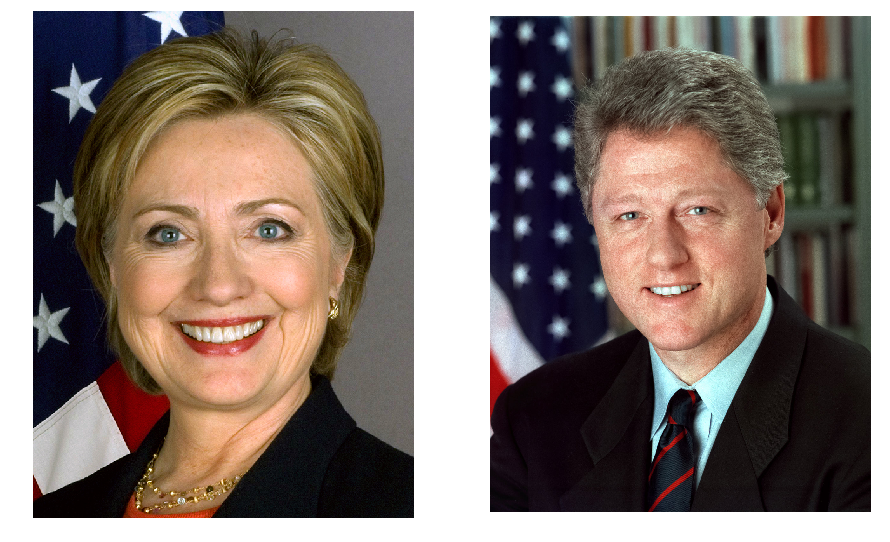

In [40]:
# Read two images
im1 = cv2.imread("data/images/hillary-clinton.jpg")
im2 = cv2.imread("data/images/presidents/bill-clinton.jpg")

imshow2(im1, im2)

## Step 4: Detect landmarks in both images

In [41]:
# Detect landmarks in both images.
points1 = fbc.getLandmarks(faceDetector, landmarkDetector, im1)
points2 = fbc.getLandmarks(faceDetector, landmarkDetector, im2)
    
points1 = np.array(points1)
points2 = np.array(points2)

# Convert image to floating point in the range 0 to 1
im1 = np.float32(im1)/255.0
im2 = np.float32(im2)/255.0

## Step 5: Normalize images and landmarks to output coordinates

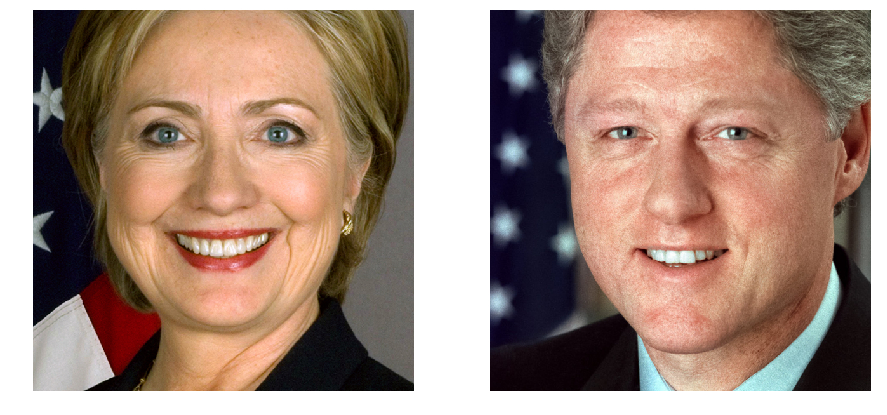

In [42]:
# Dimensions of output image
h = 600
w = 600

# Normalize image to output coordinates.
imNorm1, points1 = fbc.normalizeImagesAndLandmarks((h, w), im1, points1)
imNorm2, points2 = fbc.normalizeImagesAndLandmarks((h, w), im2, points2)

imshow2(imNorm1, imNorm2)

## Step 6: Delaunay Triangulation on Average Points

In [43]:
# Calculate average points. Will be used for Delaunay triangulation.
pointsAvg = (points1 + points2)/2.0

# 8 Boundary points for Delaunay Triangulation
boundaryPoints = fbc.getEightBoundaryPoints(h, w)
points1 = np.concatenate((points1, boundaryPoints), axis=0)
points2 = np.concatenate((points2, boundaryPoints), axis=0)
pointsAvg = np.concatenate((pointsAvg, boundaryPoints), axis=0)

# Calculate Delaunay triangulation.
rect = (0, 0, w, h)
dt = fbc.calculateDelaunayTriangles(rect, pointsAvg)

## Step 7: Animate using parameter $\alpha$

In [44]:
alpha = 0
increaseAlpha = True
count = 0
while True:
    count += 1
    writeFileName = "faceMorphing/faceMorphing" + str(count).zfill(4) + ".png"
    # Compute landmark points based on morphing parameter alpha
    pointsMorph = (1 - alpha) * points1 + alpha * points2

    # Warp images such that normalized points line up with morphed points.
    imOut1 = fbc.warpImage(imNorm1, points1, pointsMorph.tolist(), dt)
    imOut2 = fbc.warpImage(imNorm2, points2, pointsMorph.tolist(), dt)

    # Blend warped images based on morphing parameter alpha
    imMorph = (1 - alpha) * imOut1 + alpha * imOut2
    
    # Keep animating by ensuring alpha stays between 0 and 1.
    if (alpha <= 0 and not increaseAlpha):
        increaseAlpha = True
    if (alpha >= 1 and increaseAlpha):
        increaseAlpha = False

    if increaseAlpha:
        alpha += 0.025
    else:
        alpha -= 0.025
    
    imMorph*=255
    cv2.imwrite(writeFileName,imMorph)

    # Stop the program.
    if count == 80:
        break

## Step 8: Create animation from images

In [45]:
!convert faceMorphing/faceMorphing*.png -loop 0 -delay 100 results/faceMorphingAnimation.gif
!rm faceMorphing/*

# Animation

![Face Morphing Animation](results/faceMorphingAnimation.gif)